## TO DOs
- Do something about @ and mention? 
- Document preprocessing function 
- Functionalize plotting distributions including by class
- Titles and labels on all plots, clean up plots(line plots could be something else? network and t-sne word modeling need to have cleaner appearance)
- standardize plot views
- Labels and titles on all plots, legends where appropriate
- Move imports up to top 
- Note any code that’s been repurposed and its source
- Trigrams  and n grams
-  LDA modeling
- Compare metrics between different classifiers, sampling strategies
- Detail what min max scaling does and how SVMs are ‘scale sensitive’
- Functionalize clases balance chart
- Functionalize running classifiers? Or put them in a loop?
- Iteration through k best and/or recursive feature elimination
- Clean up top positive and negative coefficients from text_feature to feature in the y ticks, give a sense of scale of the coefficients’ impacts
- Better print out the accompanying text, do a list of features that do not have accompanying text in the original df or find their equivalents via indexing?
- Best model results and interpretations
- 1 to 3+ business recommendations
- Detail future work 
- Presentation 
- Video
- Blog post

# Designing a reliable product sentiment analyzer: a classification of Tweets regarding Apple and Google

## Business value: 
Being able to reliably classify tweets allows for a jumping off point for further analysis and modeling, as well as more ability to choose which tweets to examine for other use cases.

## Business use case: 
By identifying the negative and positive sentiments about Apple and Google, a tech business from the outside would be able to better understand the strategies, successes and blunders in the eye of the public for two tech giants. This would allow them to better their business by avoiding past mistakes or customer paint points and bouncing off of the successes of these companies.

## Evaluation: 

Cohen's Kappa score has been chosen as the metric of evaluation, especially fit for the imbalanced dataset and measuring the reliability of the classifier, how precise it is compared to being rated by chance. A robust and reliable classifier is needed for this business case due to how noisy and complicated twitter data can be.

# Imports and reading in data: TBD- clean this up

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import yellowbrick
import tensorflow as tf
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

Using TensorFlow backend.
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn import metrics
import missingno as msno
import plotly.express as px

In [3]:
plt.style.use('seaborn-talk')
import warnings
warnings.filterwarnings("ignore")

## Reading in data

In [4]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")

df.head(20)

tweet_text  \
0   .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1   @jessedee Know about @fludapp ? Awesome iPad/i...   
2   @swonderlin Can not wait for #iPad 2 also. The...   
3   @sxsw I hope this year's festival isn't as cra...   
4   @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5   @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                 NaN   
7   #SXSW is just starting, #CTIA is around the co...   
8   Beautifully smart and simple idea RT @madebyma...   
9   Counting down the days to #sxsw plus strong Ca...   
10  Excited to meet the @samsungmobileus at #sxsw ...   
11  Find &amp; Start Impromptu Parties at #SXSW Wi...   
12  Foursquare ups the game, just in time for #SXS...   
13  Gotta love this #SXSW Google Calendar featurin...   
14  Great #sxsw ipad app from @madebymany: http://...   
15  haha, awesomely rad iPad app by @madebymany ht...   
16  Holler Gram for iPad on the iTunes App Store -...   
17  I just noticed DST is coming this weekend. How...   
18  Just added my #SXSW flights to @planely. Match...   
19  Must have #SXSW app! RT @malbonster: Lovely re...   

    emotion_in_tweet_is_directed_at  \
0                            iPhone   
1                iPad or iPhone App   
2                              iPad   
3                iPad or iPhone App   
4                            Google   
5                               NaN   
6                               NaN   
7                           Android   
8                iPad or iPhone App   
9                             Apple   
10                          Android   
11                      Android App   
12                      Android App   
13  Other Google product or service   
14               iPad or iPhone App   
15               iPad or iPhone App   
16                              NaN   
17                           iPhone   
18               iPad or iPhone App   
19               iPad or iPhone App   

   is_there_an_emotion_directed_at_a_brand_or_product  
0                                    Negative emotion  
1                                    Positive emotion  
2                                    Positive emotion  
3                                    Negative emotion  
4                                    Positive emotion  
5                  No emotion toward brand or product  
6                  No emotion toward brand or product  
7                                    Positive emotion  
8                                    Positive emotion  
9                                    Positive emotion  
10                                   Positive emotion  
11                                   Positive emotion  
12                                   Positive emotion  
13                                   Positive emotion  
14                                   Positive emotion  
15                                   Positive emotion  
16                 No emotion toward brand or product  
17                                   Negative emotion  
18                                   Positive emotion  
19                                   Positive emotion

In [5]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

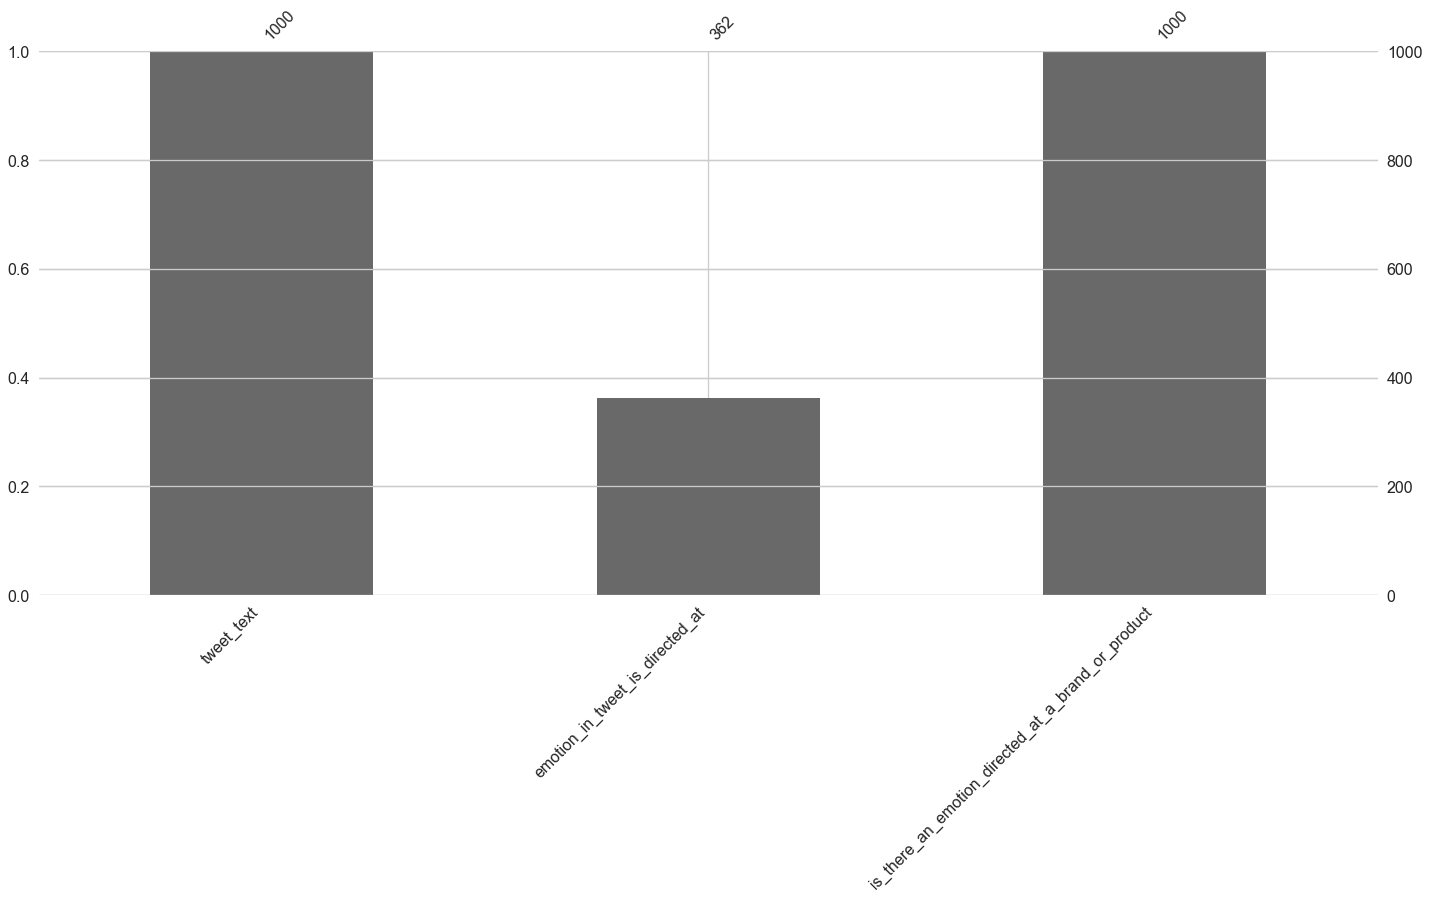

In [6]:
msno.bar(df.sample(1000))

## Dropping product/company tweet emotion is directed at
### Rationale: 
Dropping this feature to focus on the text itself and later, statistics regarding the text, to make a more generalizable classifier than including information about the direction of the tweet, as well as a significant amount of null values compromising this feature.

In [7]:
df = df.drop('emotion_in_tweet_is_directed_at', axis=1)

df.isnull().sum()

tweet_text                                            1
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

## Severe class imbalance of Neutral type tweets vs. Positive and especially Negative tweets

In [8]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [9]:
df = df.dropna()

In [10]:
df.isnull().sum()

tweet_text                                            0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

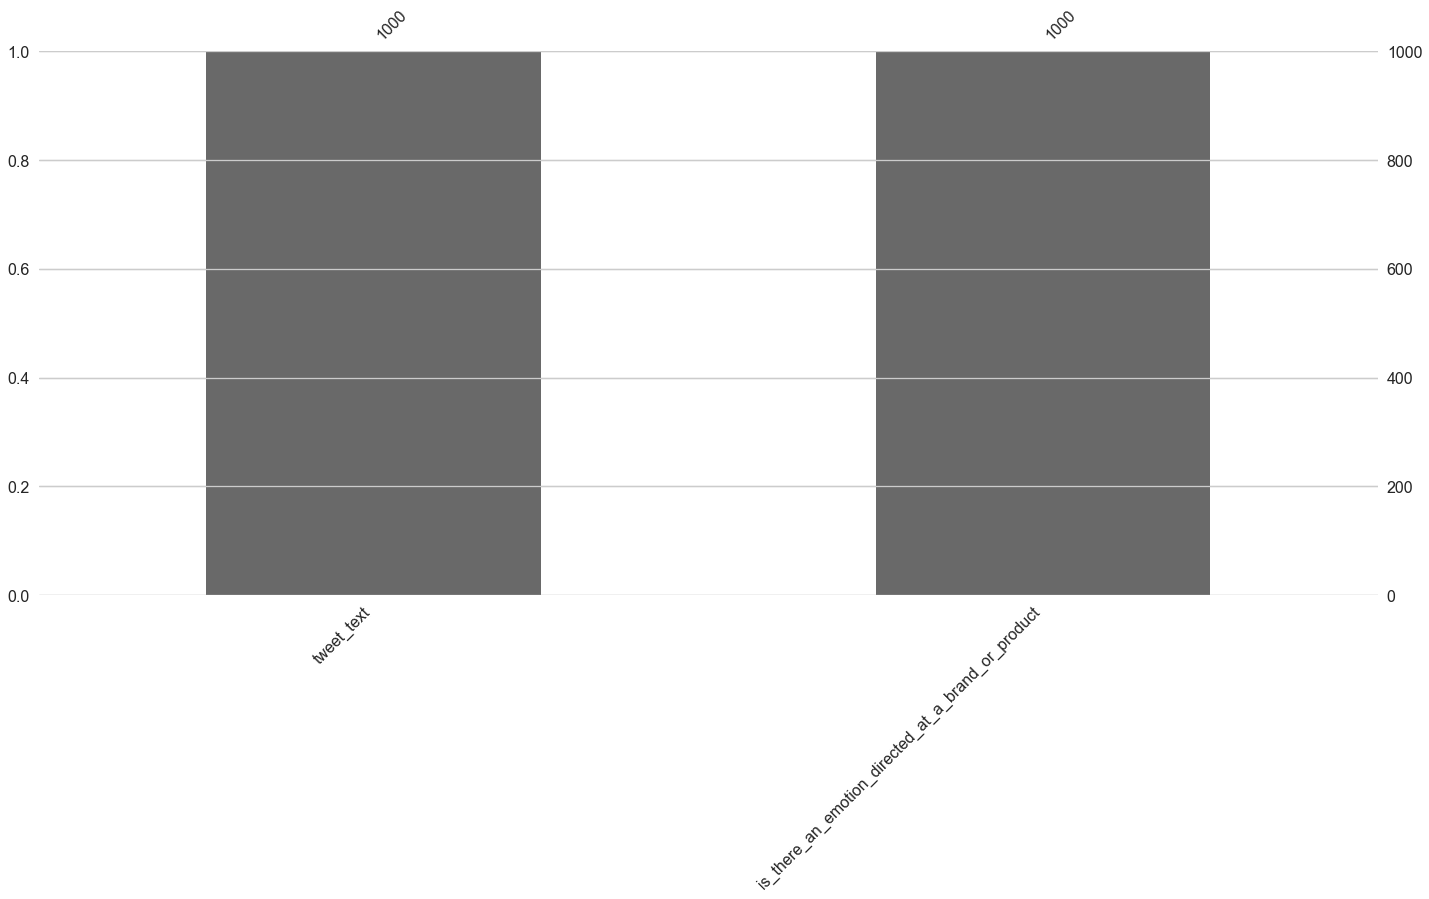

In [11]:
msno.bar(df.sample(1000))

# Preprocessing and EDA

## Renaming columns

In [12]:
df = df.rename(columns={"tweet_text": "text", "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})
df

text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...   

                               sentiment  
0                       Negative emotion  
1                       Positive emotion  
2                       Positive emotion  
3                       Negative emotion  
4                       Positive emotion  
...                                  ...  
9088                    Positive emotion  
9089  No emotion toward brand or product  
9090  No emotion toward brand or product  
9091  No emotion toward brand or product  
9092  No emotion toward brand or product  

[9092 rows x 2 columns]

## Mapping sentiment to increasingly positive: 0 for negative, 1 for neutral, 2 for positive

In [13]:
df.sentiment = df.sentiment.map({'Positive emotion': 2, 'Negative emotion': 0, 'No emotion toward brand or product': 1, "I can't tell":1})

In [14]:
df.sentiment.value_counts(dropna=False)

1    5544
2    2978
0     570
Name: sentiment, dtype: int64

## Countplot shows that the majority of tweets are neutral, then positive, then few negative tweets

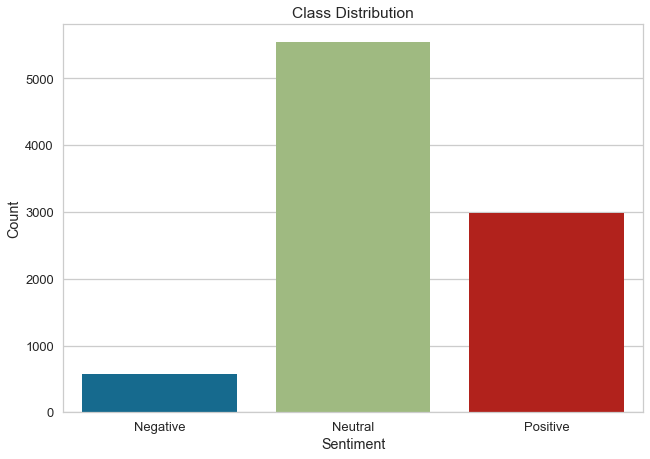

In [201]:
sns.countplot(df.sentiment)
ax = plt.gca()
ax.set_title("Class Distribution")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.set_xticklabels(['Negative','Neutral','Positive'])
plt.show()

## General text preprocessing function, creating a new dataframe(clean_df) to preserve the original text

In [16]:
def preprocess(text):
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')  
    text = text.str.replace(',','')
    text = text.str.replace('{', '')
    text = text.str.replace('}', '')
    text = text.str.replace('.', '')
    text = text.str.replace(':', '')
    text = text.str.replace('-', '')
    return text

clean_df = df 
clean_df['text'] = preprocess(clean_df['text'])

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

## Creating new features
Creating features out of the length of a tweet, words in a tweet, and amounts of hashtags, capital words, exclamation/question marks, the mean length of a word in a tweet, the count of unique words in a tweet, and the percentage of unique words in a tweet.

In [17]:
def tweet_special_count(string, character):
    '''Splits string by word, and returns the count of a given character in a tweet'''
    w = string.split()
    
    char = [word for word in w if word.startswith(character)]
    
    return len(char)

In [18]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()



text  sentiment  tweet_len  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0        122   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          2        137   
2  @swonderlin Can not wait for #iPad 2 also They...          2         77   
3  @sxsw I hope this year's festival isn't as cra...          0         81   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          2        125   

   tweet_words  hash_cnt  mention_cnt  capital_words  excl_q_marks  \
0           23         2            1              1             1   
1           22         1            2              1             1   
2           15         2            1              1             0   
3           15         1            1              0             0   
4           17         1            1              1             0   

   mean_word_len  count_unique_word  word_unique_percent  
0       4.304348                 21            91.304348  
1       5.272727                 22           100.000000  
2       4.200000                 15           100.000000  
3       4.466667                 12            80.000000  
4       6.411765                 17           100.000000

In [19]:
clean_df.columns

Index(['text', 'sentiment', 'tweet_len', 'tweet_words', 'hash_cnt',
       'mention_cnt', 'capital_words', 'excl_q_marks', 'mean_word_len',
       'count_unique_word', 'word_unique_percent'],
      dtype='object')

# Summary stats and visuals

## Top tokens - items and products with named entity recognition

In [20]:
from collections import Counter
tokens = nlp(''.join(str(df.text.tolist())))
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('Apple', 1122),
 ('iPhone', 843),
 ('Google', 775),
 ('SXSW', 750),
 ('Austin', 642),
 ('2', 490),
 ('today', 301),
 ('#sxsw #', 266),
 ('Today', 235),
 ('#sxsw', 234),
 ('Android', 232),
 ('#SXSW #', 232),
 ('sxsw', 152),
 ('Launch Major New Social Network', 152),
 ('Circles', 142),
 ('RT @mention', 138),
 ('SxSW', 107),
 ('iPad2', 95),
 ('RT @mention Google', 94),
 ("'RT @mention", 94)]

## Between Apple and its iPad 2, Apple seems to dominate over Google in this dataset. 
Of interest is "Circles", the new Google social network launch rumored at the time (evidently during South by Southwest Festival in Austin, Texas)[TBD: link].

### Most common tokens W/ identified Entities

In [21]:
item_cnt = Counter(items).most_common(20)
df_items = pd.DataFrame(item_cnt, columns =['text', 'count'])


fig = px.bar(df_items, y="text", x="count", orientation='h',title="Most Common Tokens W/ Entities Mentioned")
fig.show()

### Most Common Products

In [22]:
products = []
for ent in tokens.ents:
    if ent.label_ == 'PRODUCT':
        products.append(ent.text)
        
prdct_cnt = Counter(products).most_common(20)
df_prod = pd.DataFrame(prdct_cnt, columns =['text', 'count'])

fig = px.bar(df_prod, y="text", x="count", orientation='h',title="Most Common Products Mentioned")
fig.show()

## Analysis of numerical features- TBD: Class-by-class, more full writeup
### Distributions:
Tweet length, amount of words in tweet, and count of unique words stand out as look Gaussian/normal.

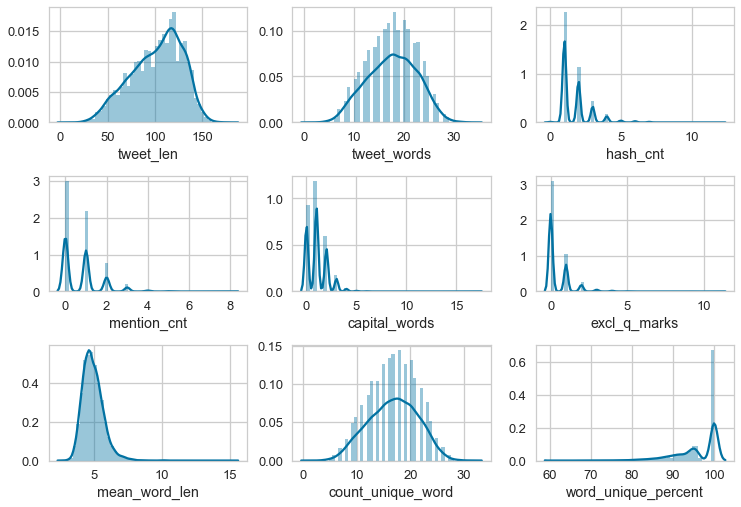

In [23]:
fig, axs = plt.subplots(ncols=3, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

### Correlation matrix - looks like not much correlation/colinearity, no values above +.30 and none below -.45

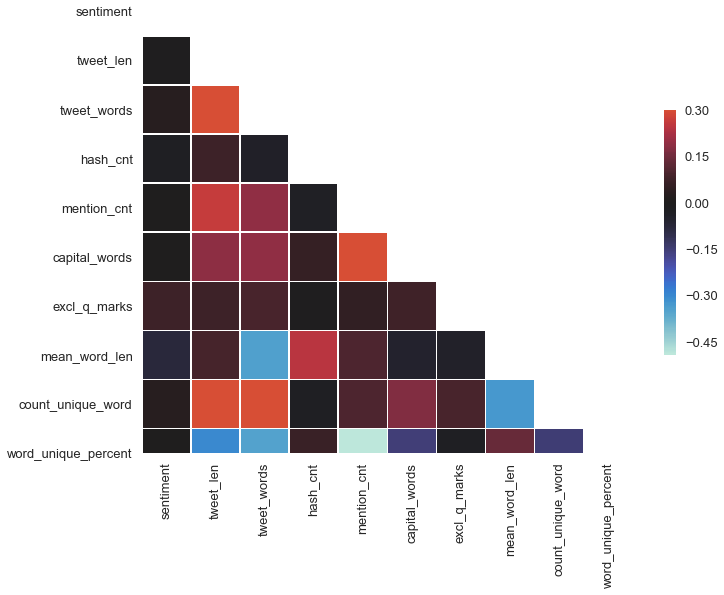

In [24]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Pairplot

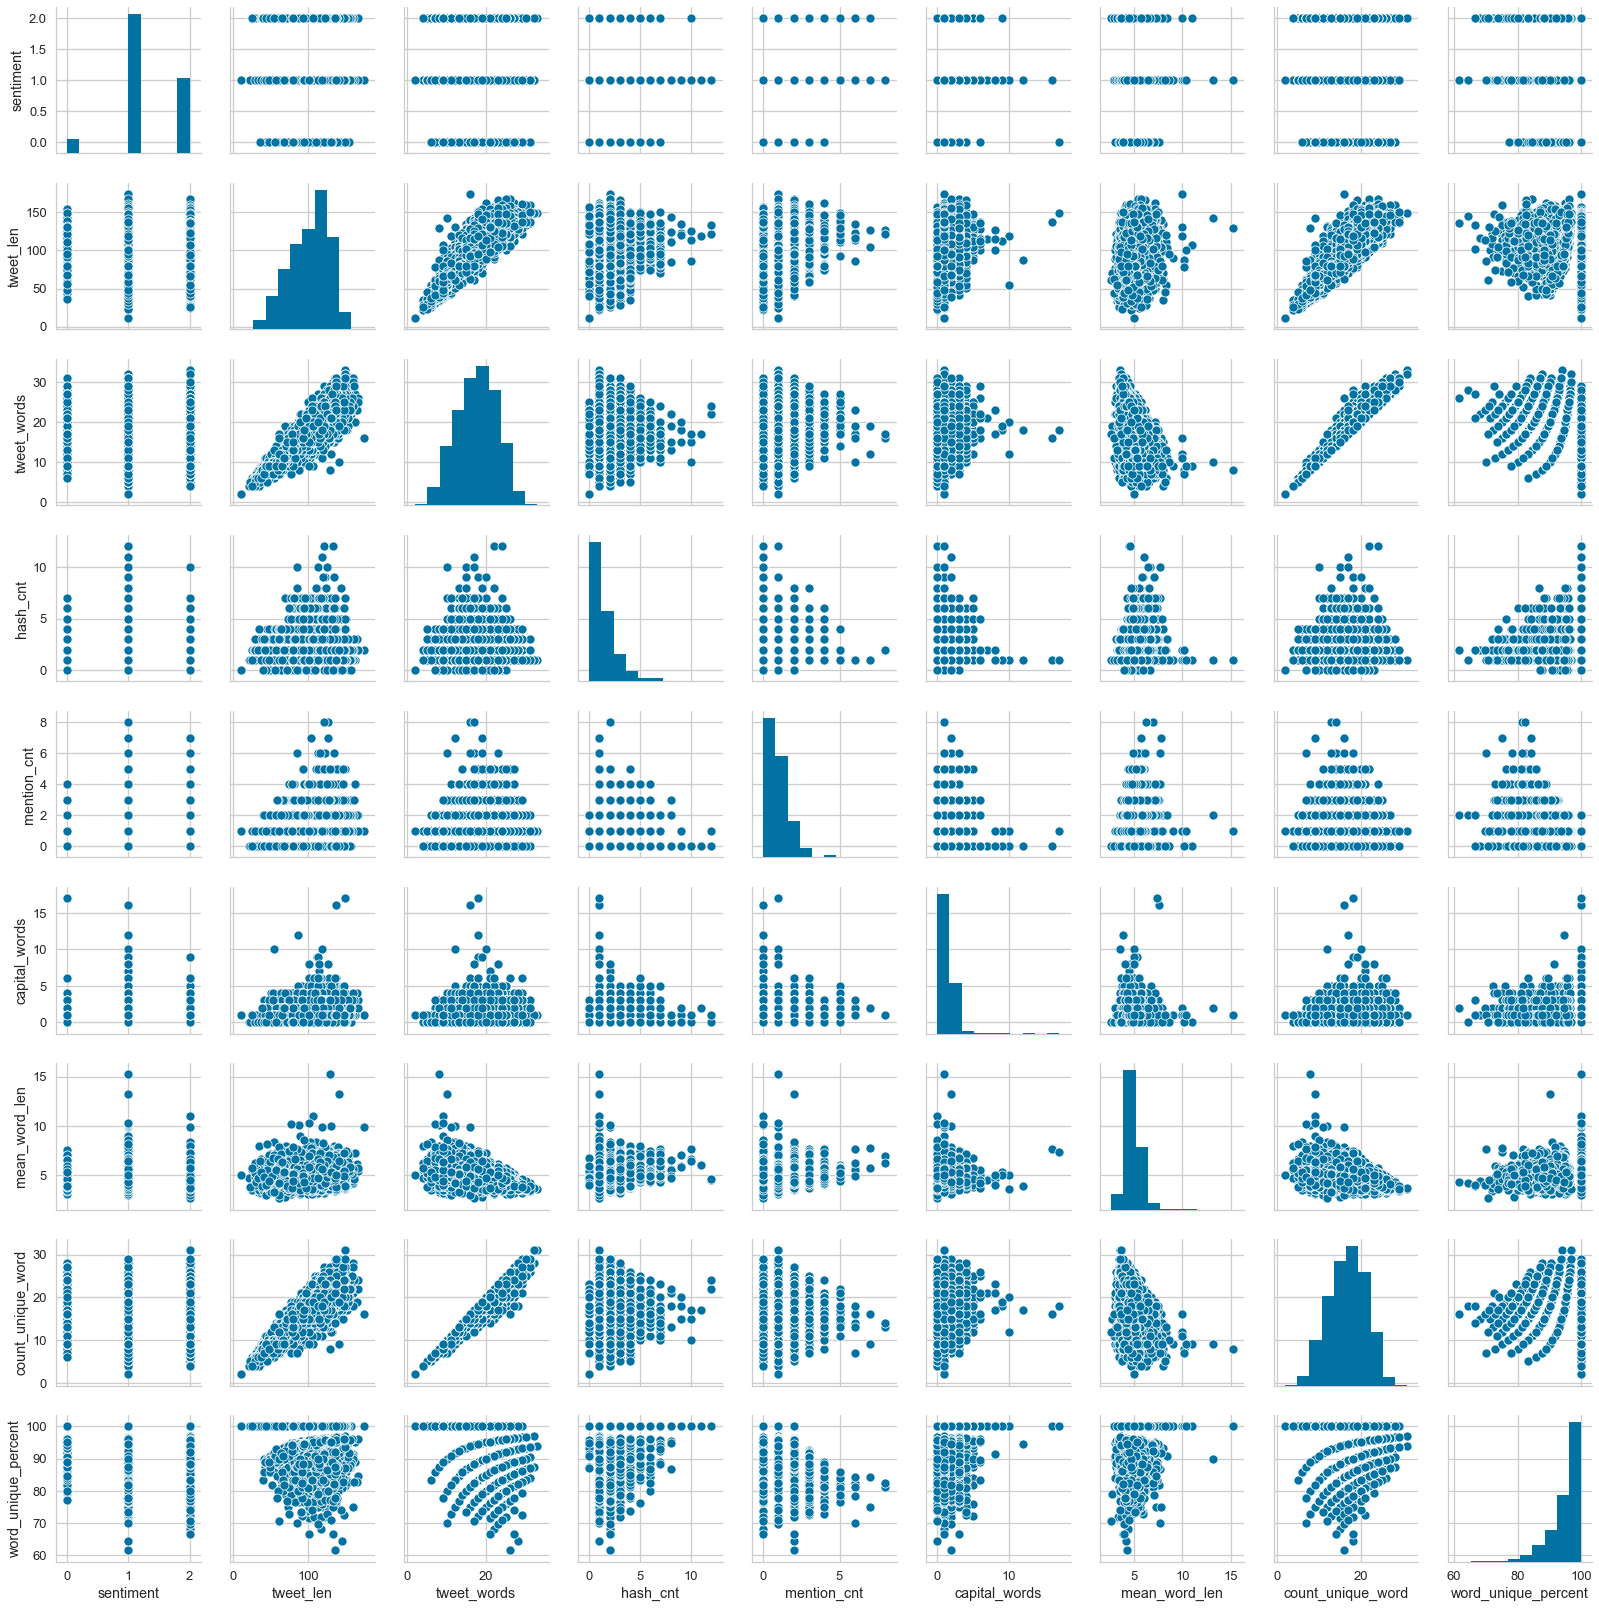

In [25]:
sns.pairplot(clean_df[[ 'sentiment', 'tweet_len','tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words','mean_word_len', 'count_unique_word', 'word_unique_percent']])
# 'direction'

#### Dropping tweet_len due to high correlation with tweet_words and unique words

In [26]:
clean_df = clean_df.drop('tweet_len',axis=1)

clean_df.head()

text  sentiment  tweet_words  \
0  @wesley83 I have a 3G iPhone After 3 hrs tweet...          0           23   
1  @jessedee Know about @fludapp ? Awesome iPad/i...          2           22   
2  @swonderlin Can not wait for #iPad 2 also They...          2           15   
3  @sxsw I hope this year's festival isn't as cra...          0           15   
4  @sxtxstate great stuff on Fri #SXSW Marissa Ma...          2           17   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0         2            1              1             1       4.304348   
1         1            2              1             1       5.272727   
2         2            1              1             0       4.200000   
3         1            1              0             0       4.466667   
4         1            1              1             0       6.411765   

   count_unique_word  word_unique_percent  
0                 21            91.304348  
1                 22           100.000000  
2                 15           100.000000  
3                 12            80.000000  
4                 17           100.000000

# Further preprocessing - tokenizing and lemmatizing, stopword removal

In [27]:
clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hrs tweet...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

## Initial Wordcloud for comparison of prominent text

In [28]:
from wordcloud import WordCloud

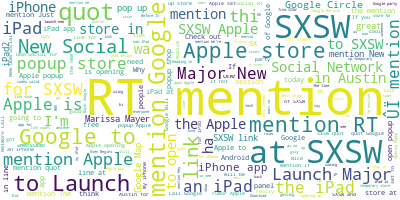

In [29]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

## Sentence by sentence stemming and visualization

In [30]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def stem_sentences(sentence):
    tokens = sentence.split()
    lemma_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemma_tokens)

clean_df['text'] = clean_df['text'].apply(stem_sentences)

clean_df['text']

0       @wesley83 I have a 3G iPhone After 3 hr tweeti...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also They...
3       @sxsw I hope this year's festival isn't a cras...
4       @sxtxstate great stuff on Fri #SXSW Marissa Ma...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt your regula...
9090    Google's Zeiger a physician never reported pot...
9091    Some Verizon iPhone customer complained their ...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

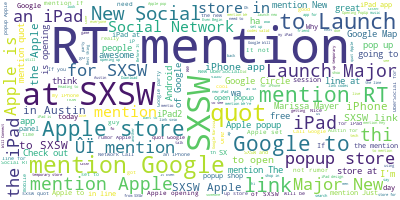

In [31]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

## Removal of stopwords and corresponding visual

In [32]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelburak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
clean_df['text'] = clean_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_list)]))

clean_df['text']

0       @wesley83 I 3G iPhone After 3 hr tweeting #RIS...
1       @jessedee Know @fludapp ? Awesome iPad/iPhone ...
2       @swonderlin Can wait #iPad 2 also They sale #SXSW
3       @sxsw I hope year's festival crashy year's iPh...
4       @sxtxstate great stuff Fri #SXSW Marissa Mayer...
                              ...                        
9088                           Ipad everywhere #SXSW link
9089    Wave buzz RT @mention We interrupt regularly s...
9090    Google's Zeiger physician never reported poten...
9091    Some Verizon iPhone customer complained time f...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

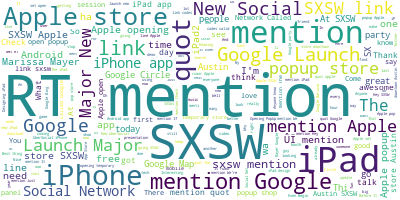

In [34]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud.generate(clean_df['text'].to_string())

wordcloud.to_image()

# Features after cleaning and analysis

In [35]:
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df["mean_word_len"] = clean_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
clean_df['count_unique_word']=clean_df["text"].apply(lambda x: len(set(str(x).split())))
clean_df['word_unique_percent']=clean_df['count_unique_word']*100/clean_df['tweet_words']
clean_df.head()

text  sentiment  tweet_words  \
0  @wesley83 I 3G iPhone After 3 hr tweeting #RIS...          0           17   
1  @jessedee Know @fludapp ? Awesome iPad/iPhone ...          2           16   
2  @swonderlin Can wait #iPad 2 also They sale #SXSW          2            9   
3  @sxsw I hope year's festival crashy year's iPh...          0           10   
4  @sxtxstate great stuff Fri #SXSW Marissa Mayer...          2           16   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0         2            1              1             1       4.882353   
1         1            2              1             1       5.812500   
2         2            1              1             0       4.555556   
3         1            1              0             0       5.000000   
4         1            1              1             0       6.687500   

   count_unique_word  word_unique_percent  
0                 16            94.117647  
1                 16           100.000000  
2                  9           100.000000  
3                  9            90.000000  
4                 16           100.000000

## Distribution of features: 
The distribution of features remains similar, likely due to mostly preserving word content.

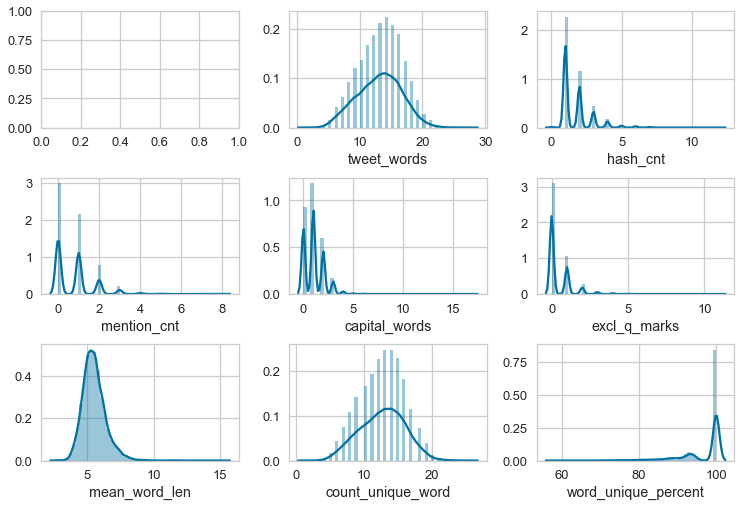

In [36]:
fig, axs = plt.subplots(ncols=3, nrows=3)
# sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[0][2])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][0])
sns.distplot(clean_df['capital_words'], ax=axs[1][1])
sns.distplot(clean_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(clean_df['mean_word_len'], ax=axs[2][0])
sns.distplot(clean_df['count_unique_word'], ax=axs[2][1])
sns.distplot(clean_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

## Creating negative and positive dataframes

In [37]:
pos_df = clean_df.loc[clean_df['sentiment'] == 2]
neg_df = clean_df.loc[clean_df['sentiment'] == 0]
pos_df.head()

text  sentiment  tweet_words  \
1  @jessedee Know @fludapp ? Awesome iPad/iPhone ...          2           16   
2  @swonderlin Can wait #iPad 2 also They sale #SXSW          2            9   
4  @sxtxstate great stuff Fri #SXSW Marissa Mayer...          2           16   
7  #SXSW starting #CTIA around corner #googleio h...          2           13   
8  Beautifully smart simple idea RT @madebymany @...          2           13   

   hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
1         1            2              1             1       5.812500   
2         2            1              1             0       4.555556   
4         1            1              1             0       6.687500   
7         4            0              2             0       5.307692   
8         2            2              1             1       7.461538   

   count_unique_word  word_unique_percent  
1                 16                100.0  
2                  9                100.0  
4                 16                100.0  
7                 13                100.0  
8                 13                100.0

In [38]:
neg_df.head()

text  sentiment  tweet_words  \
0   @wesley83 I 3G iPhone After 3 hr tweeting #RIS...          0           17   
3   @sxsw I hope year's festival crashy year's iPh...          0           10   
17  I noticed DST coming weekend How many iPhone u...          0           17   
38  @mention False Alarm Google Circles Not Coming...          0           16   
64   Again? RT @mention Line Apple store insane #sxsw          0            8   

    hash_cnt  mention_cnt  capital_words  excl_q_marks  mean_word_len  \
0          2            1              1             1       4.882353   
3          1            1              0             0       5.000000   
17         2            0              3             1       4.882353   
38         4            1              1             1       6.000000   
64         1            1              1             1       5.125000   

    count_unique_word  word_unique_percent  
0                  16            94.117647  
3                   9            90.000000  
17                 17           100.000000  
38                 15            93.750000  
64                  8           100.000000

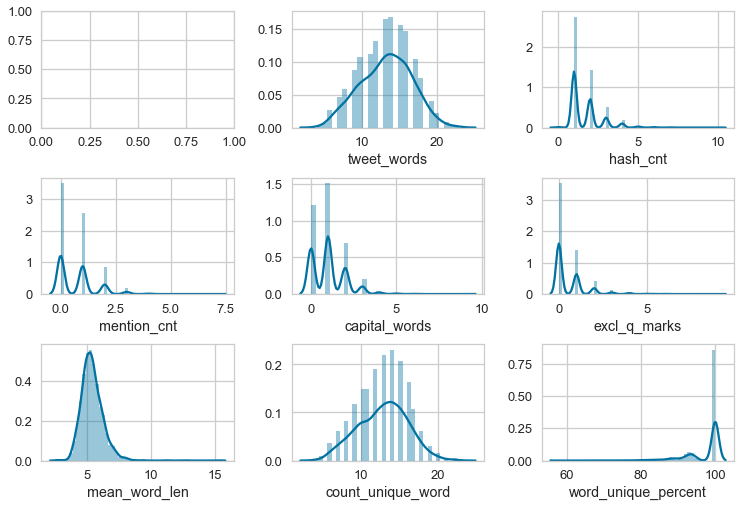

In [39]:
fig, axs = plt.subplots(ncols=3, nrows=3)
# sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(pos_df['tweet_words'], ax=axs[0][1])
sns.distplot(pos_df['hash_cnt'], ax=axs[0][2])
sns.distplot(pos_df['mention_cnt'], ax=axs[1][0])
sns.distplot(pos_df['capital_words'], ax=axs[1][1])
sns.distplot(pos_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(pos_df['mean_word_len'], ax=axs[2][0])
sns.distplot(pos_df['count_unique_word'], ax=axs[2][1])
sns.distplot(pos_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

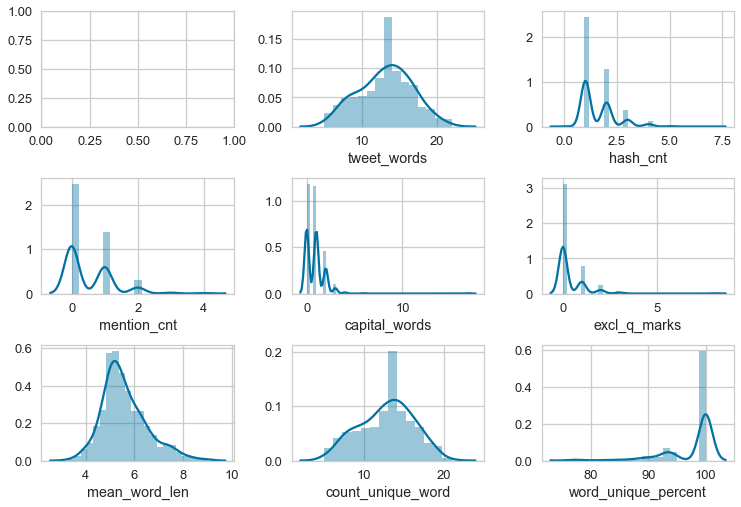

In [40]:
fig, axs = plt.subplots(ncols=3, nrows=3)
# sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(neg_df['tweet_words'], ax=axs[0][1])
sns.distplot(neg_df['hash_cnt'], ax=axs[0][2])
sns.distplot(neg_df['mention_cnt'], ax=axs[1][0])
sns.distplot(neg_df['capital_words'], ax=axs[1][1])
sns.distplot(neg_df['excl_q_marks'], ax=axs[1][2])
sns.distplot(neg_df['mean_word_len'], ax=axs[2][0])
sns.distplot(neg_df['count_unique_word'], ax=axs[2][1])
sns.distplot(neg_df['word_unique_percent'], ax=axs[2][2])
plt.tight_layout()

## Tokenizing with TweetTokenizer

In [41]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
clean_df['tokens'] = clean_df['text'].apply(tt.tokenize)

# Visuals, continued - t-Sne

## t-SNE of k-means clusters, overall document, text vs. classes

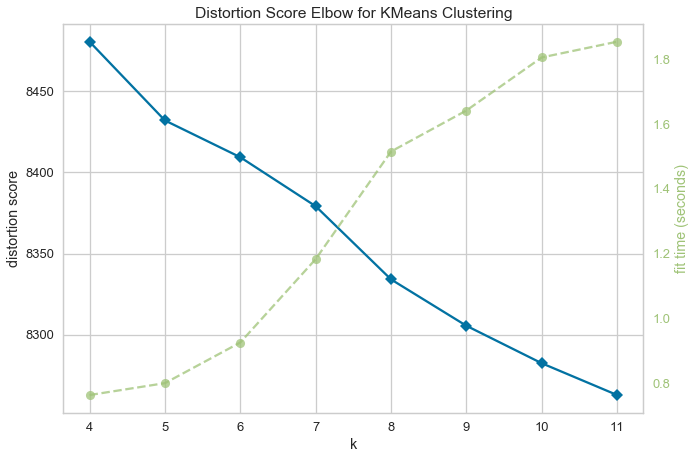

In [42]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(clean_df['text'])

tf_words = tfidf.get_feature_names()

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)
visualizer.show() 

### t-SNE of K-means

In [123]:
from yellowbrick.text import TSNEVisualizer
X = tfidf.fit_transform(clean_df['text'])


In [124]:
clusters = KMeans(n_clusters=9)
clusters.fit(X)


KMeans(n_clusters=9)

### Interpretation:
Of special interest are groups of words regarding the rumored launch of Google's "Circles", a special Apple popup store in Austin that seems popular, and a Marissa Mayer's link to Google Maps. More analysis needs to go into the positioning and relationship of clusters, TBD.

W0701 18:46:11.682288 4623228352 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0701 18:46:11.695140 4623228352 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0701 18:46:11.718022 4623228352 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W0701 1

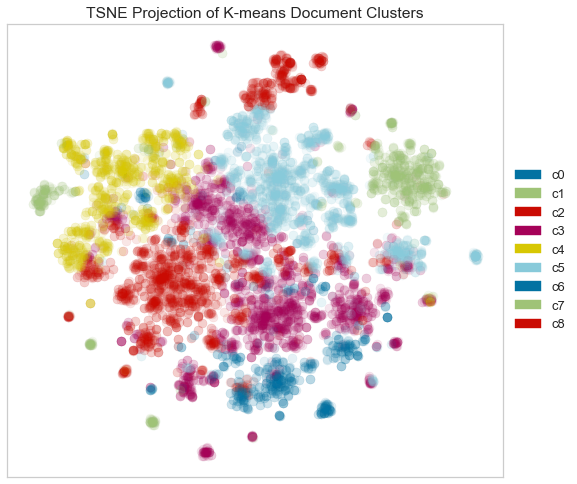

0 : app, iphone, mention, link, sxsw, new, rt, android, uberguide, ubersocial
1 : opening, downtown, temporary, austin, launch, store, apple, rumor, mention, it
2 : network, social, circles, called, launch, major, new, today, possibly, google
3 : mention, iphone, sxsw, link, rt, android, apple, free, austin, sxswi
4 : apple, store, popup, link, sxsw, mention, austin, ipad2, line, open
5 : google, mention, sxsw, link, rt, circles, mayer, mobile, party, marissa
6 : know, anyone, sxsw, apple, mention, let, store, iphone, rt, austin
7 : quot, mention, sxsw, google, rt, ipad, apple, heard, link, go
8 : ipad, sxsw, mention, link, rt, win, the, design, new, line


In [195]:
tsne = TSNEVisualizer(size=(800, 600), title="TSNE Projection of K-means Document Clusters", alpha=0.1,random_state=0)
tsne.fit(X, ["c{}".format(c) for c in clusters.labels_])
tsne.show()
common_words = clusters.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(tf_words[word] for word in centroid))
    


### TSNE of tweet text
### Interpretation: 
The documents cluster very much around the center, but there are plenty of outlying documents.

W0701 18:41:38.308473 4623228352 _axes.py:4271] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


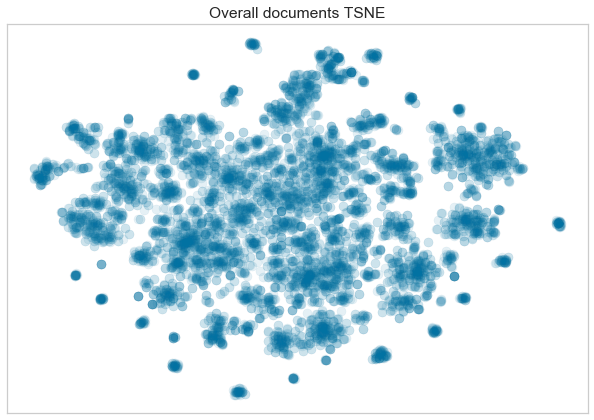

In [189]:
tsne = TSNEVisualizer(random_state=0,alpha=0.1, title="Overall documents TSNE")
tsne.fit(X)
tsne.show()

### TSNE of tweet text and sentiment
### Interpretation:
Neutral sentiment dominates, fitting with the class imbalance. Negative classes can hardly be seen in this projection, while there are some outlying positive class records.

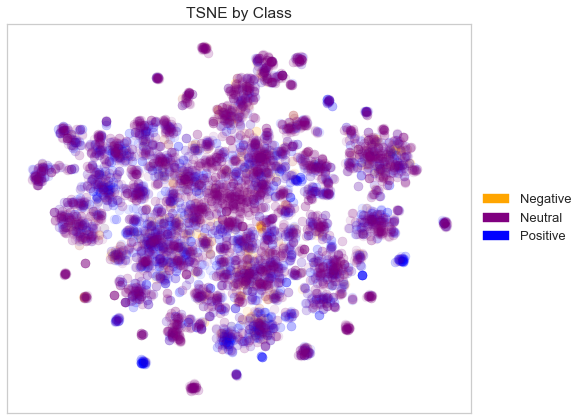

In [190]:
y = clean_df['sentiment'].replace({0:"Negative",1:"Neutral",2:"Positive"})
tsne = TSNEVisualizer(random_state=0, title="TSNE by Class",colors=('orange','purple','blue'), alpha=0.1)
tsne.fit(X,y)

tsne.show()

### Word modeling t-SNE

In [148]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [149]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(clean_df)        
corpus[0:2]

[['@wesley83',
  'I',
  '3G',
  'iPhone',
  'After',
  '3',
  'hr',
  'tweeting',
  '#RISE_Austin',
  'wa',
  'dead!',
  'I',
  'need',
  'upgrade',
  'Plugin',
  'station',
  '#SXSW'],
 ['@jessedee',
  'Know',
  '@fludapp',
  '?',
  'Awesome',
  'iPad/iPhone',
  'app',
  'likely',
  'appreciate',
  'design',
  'Also',
  "they're",
  'giving',
  'free',
  'Ts',
  '#SXSW']]

In [150]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)
model.wv['Google']

array([-0.07109796, -0.08871707, -0.03495851,  0.15544848,  0.32567057,
        0.33802387,  0.01681371, -0.04308857,  0.20471422, -0.18274951,
        0.28848973, -0.23642045,  0.0047352 , -0.23160559, -0.06405289,
       -0.05964615,  0.12477676,  0.17854504,  0.19802386,  0.17911194,
        0.21160007, -0.31515563,  0.08846273, -0.1264955 ,  0.19638076,
       -0.08082428,  0.00430111,  0.11578211, -0.23107035,  0.20500055,
        0.14075947, -0.20257607,  0.14854175,  0.14993286,  0.07246972,
       -0.36691394,  0.3559293 ,  0.0888146 ,  0.51189744, -0.01781841,
       -0.04226852,  0.28654736,  0.07344647,  0.09393225,  0.02521041,
       -0.22316805, -0.24367744, -0.09721012, -0.20099866,  0.06708852,
        0.2855253 , -0.07211763,  0.0303857 , -0.04556376, -0.16706842,
       -0.37401533, -0.30666175,  0.16113192,  0.02436299,  0.04004802,
       -0.10635512,  0.21956782,  0.07694203, -0.11701338, -0.47158095,
        0.00872623, -0.02980415, -0.33046573,  0.04332145,  0.47

### TBD: Interpretation

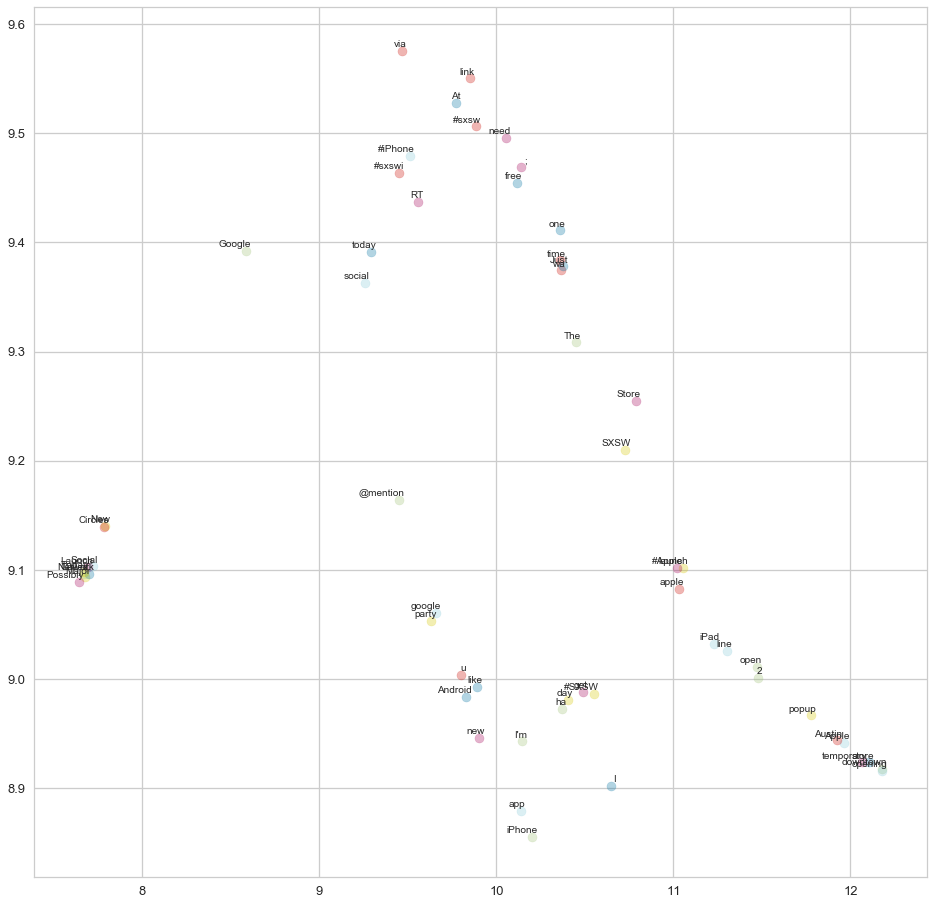

In [151]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i], alpha=0.3)
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model)

# Word2Vec Similarities and plots

## Google interpretation: 
Google's word similarities heavily center around the launch of the Circles network rumored at the time.

In [153]:
google_similar = model.most_similar('Google')

google_similar

[('New', 0.9899075031280518),
 ('Circles', 0.9889025688171387),
 ('Social', 0.9879493713378906),
 ('Network', 0.9871532320976257),
 ('Called', 0.9839340448379517),
 ('Launch', 0.983932614326477),
 ('Today', 0.982510507106781),
 ('Possibly', 0.9803218841552734),
 ('Major', 0.9791979193687439),
 ('social', 0.8889600038528442)]

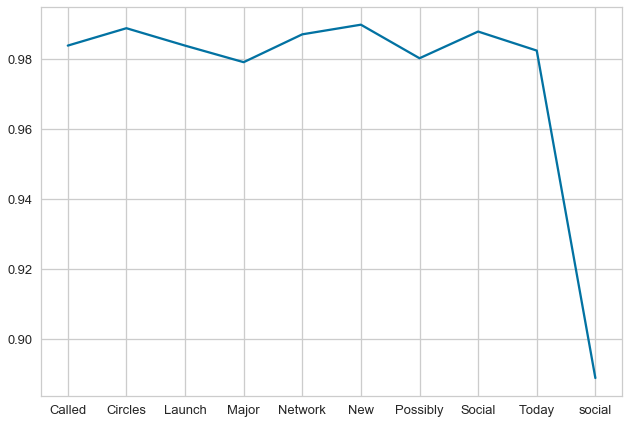

In [154]:
sns.lineplot(*zip(*google_similar))

## Apple interpretation:
Apple's word similarities heavily focus on the opening of a temporary popup store in downtown Austin and the iPad 2.

In [155]:
apple_similar = model.most_similar('Apple')

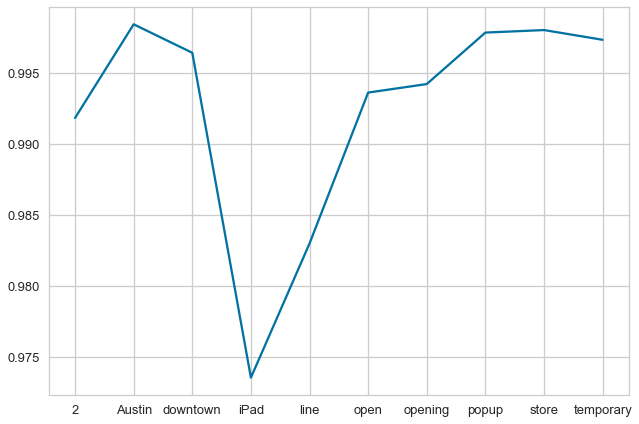

In [156]:
sns.lineplot(*zip(*apple_similar))

# Bigrams and N-grams

In [157]:
from nltk import bigrams

In [158]:
clean_df['tokens']

0       [@wesley83, I, 3G, iPhone, After, 3, hr, tweet...
1       [@jessedee, Know, @fludapp, ?, Awesome, iPad, ...
2       [@swonderlin, Can, wait, #iPad, 2, also, They,...
3       [@sxsw, I, hope, year's, festival, crashy, yea...
4       [@sxtxstate, great, stuff, Fri, #SXSW, Marissa...
                              ...                        
9088                      [Ipad, everywhere, #SXSW, link]
9089    [Wave, buzz, RT, @mention, We, interrupt, regu...
9090    [Google's, Zeiger, physician, never, reported,...
9091    [Some, Verizon, iPhone, customer, complained, ...
9092    [, Ï, ¡, , Ïà, , ü_, , , Ê, , , Î, , ...
Name: tokens, Length: 9092, dtype: object

In [159]:
#create bigrams
bigram_list = [list(bigrams(tweet)) for tweet in clean_df['tokens']]

bigram_list[:6]

[[('@wesley83', 'I'),
  ('I', '3G'),
  ('3G', 'iPhone'),
  ('iPhone', 'After'),
  ('After', '3'),
  ('3', 'hr'),
  ('hr', 'tweeting'),
  ('tweeting', '#RISE_Austin'),
  ('#RISE_Austin', 'wa'),
  ('wa', 'dead'),
  ('dead', '!'),
  ('!', 'I'),
  ('I', 'need'),
  ('need', 'upgrade'),
  ('upgrade', 'Plugin'),
  ('Plugin', 'station'),
  ('station', '#SXSW')],
 [('@jessedee', 'Know'),
  ('Know', '@fludapp'),
  ('@fludapp', '?'),
  ('?', 'Awesome'),
  ('Awesome', 'iPad'),
  ('iPad', '/'),
  ('/', 'iPhone'),
  ('iPhone', 'app'),
  ('app', 'likely'),
  ('likely', 'appreciate'),
  ('appreciate', 'design'),
  ('design', 'Also'),
  ('Also', "they're"),
  ("they're", 'giving'),
  ('giving', 'free'),
  ('free', 'Ts'),
  ('Ts', '#SXSW')],
 [('@swonderlin', 'Can'),
  ('Can', 'wait'),
  ('wait', '#iPad'),
  ('#iPad', '2'),
  ('2', 'also'),
  ('also', 'They'),
  ('They', 'sale'),
  ('sale', '#SXSW')],
 [('@sxsw', 'I'),
  ('I', 'hope'),
  ('hope', "year's"),
  ("year's", 'festival'),
  ('festival', 'cras

In [160]:
flat_bigrams = [item for sublist in bigram_list for item in sublist]

flat_bigrams[:11]

[('@wesley83', 'I'),
 ('I', '3G'),
 ('3G', 'iPhone'),
 ('iPhone', 'After'),
 ('After', '3'),
 ('3', 'hr'),
 ('hr', 'tweeting'),
 ('tweeting', '#RISE_Austin'),
 ('#RISE_Austin', 'wa'),
 ('wa', 'dead'),
 ('dead', '!')]

## Top 20 bigrams

## Interpretation:
The bigrams are dominated by phrases regarding this social network mentioned above, as well as the iPad2 and popup store again.

In [161]:
import itertools
from collections import Counter

bigram_count = Counter(flat_bigrams)

bigram_count.most_common(20)

[(('RT', '@mention'), 2855),
 (('iPad', '2'), 986),
 (('@mention', '@mention'), 566),
 (('link', '#sxsw'), 513),
 (('#SXSW', 'link'), 453),
 (('@mention', 'Google'), 361),
 (('via', '@mention'), 346),
 (('Social', 'Network'), 308),
 (('New', 'Social'), 292),
 (('@mention', '#sxsw'), 278),
 (('Network', 'Called'), 277),
 (('Major', 'New'), 267),
 (('Launch', 'Major'), 266),
 (('!', 'link'), 258),
 (('Called', 'Circles'), 255),
 (('popup', 'store'), 254),
 (('Google', 'Launch'), 253),
 (('#sxsw', 'link'), 253),
 (('link', '#SXSW'), 243),
 (('Apple', 'Store'), 236)]

In [162]:
bigram_df = pd.DataFrame(bigram_count.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

bigram  count
0         (RT, @mention)   2855
1              (iPad, 2)    986
2   (@mention, @mention)    566
3          (link, #sxsw)    513
4          (#SXSW, link)    453
5     (@mention, Google)    361
6        (via, @mention)    346
7      (Social, Network)    308
8          (New, Social)    292
9      (@mention, #sxsw)    278
10     (Network, Called)    277
11          (Major, New)    267
12       (Launch, Major)    266
13             (!, link)    258
14     (Called, Circles)    255
15        (popup, store)    254
16      (Google, Launch)    253
17         (#sxsw, link)    253
18         (link, #SXSW)    243
19        (Apple, Store)    236

## Plot of top 20 bigrams

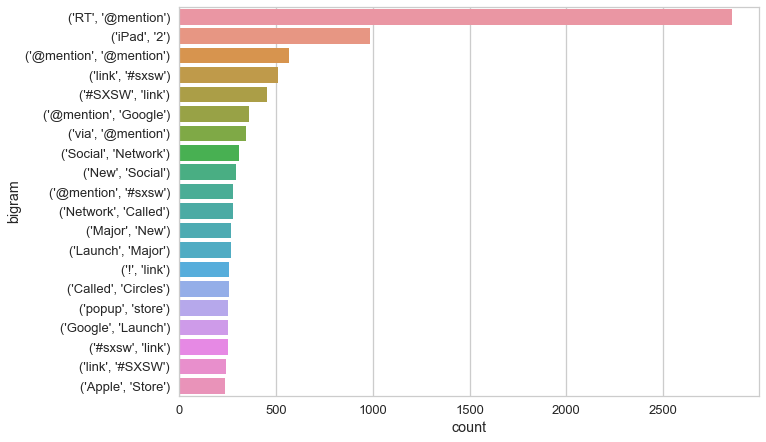

In [163]:
sns.barplot(data=bigram_df, x="count", y="bigram")

## Network plot of bigrams

### Interpretation: 
Clearly there's links between bigrams in tweets about the new social network, and the Apple popup store, when network graphed.

In [164]:
import networkx as nx


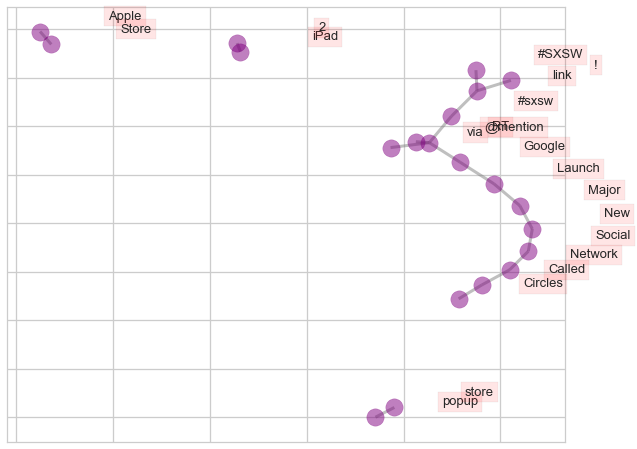

In [185]:
# Create dictionary of bigrams and their counts
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

# G.add_node("apple", weight=100)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2, seed=33)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=12,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax,
                alpha=0.5)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.175, value[1]+.050
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.1),
            horizontalalignment='center', fontsize=13)
plt.show()

### TBD: LDA visualization

# Modeling

## TBD: Multiple classifiers, tuning, better display of metrics, feature impact

In [65]:
from sklearn_pandas import DataFrameMapper, cross_val_score

## Making a scorer for grid searching out of cohen's kappa and a function for selective f-scores

In [66]:
from sklearn.metrics import cohen_kappa_score, make_scorer
kappa_scorer = make_scorer(cohen_kappa_score)

## DataFrameMapper with Tf-idf Vectorization
Note: DataFrameMapper creates a union between features, resulting in an array. TF-IDF, put simply, is a vectorization technique that takes the number of times the word appears / the number of documents containing the words, most helpfullly normalizing word frequency by dividing by the document frequency to weight common words downwards as they appear many times but in many documents, vs. other permutations of frequencies.

In [67]:
mapper = DataFrameMapper([
     ('text', TfidfVectorizer()),
     ('tweet_words', None),
    ('hash_cnt', None),
    ('mention_cnt', None),
    ('capital_words', None),
    ('excl_q_marks', None),
    ('mean_word_len',None),
    ('count_unique_word',None),
    ('word_unique_percent',None)
 ])

In [68]:
X = mapper.fit_transform(clean_df)

In [69]:
X

array([[  0.        ,   0.        ,   0.        , ...,   4.88235294,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.8125    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,   4.55555556,
          9.        , 100.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   7.        ,
         16.        ,  94.11764706],
       [  0.        ,   0.        ,   0.        , ...,   5.5625    ,
         16.        , 100.        ],
       [  0.        ,   0.        ,   0.        , ...,  10.33333333,
          9.        , 100.        ]])

## Train test splits
### Rationale: 
Standard practice, with stratifying on y to address class imbalance(reference here.)

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

## Minmax Scaling
### Rationale: 
SVMs are 'scale sensitive' (citation needed.)

In [71]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

## Comparing class balance 

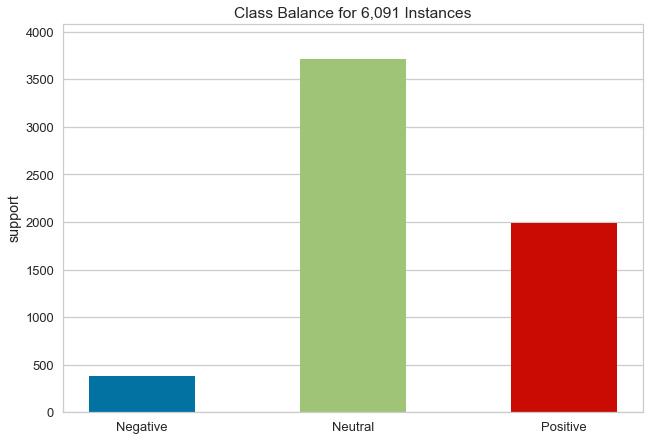

In [72]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative","Neutral", "Positive"])

visualizer.fit(y_train)
visualizer.show()

# SVC Base Model for Comparison

In [73]:
from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.48      0.29      0.36       188
           1       0.73      0.79      0.76      1830
           2       0.58      0.53      0.56       983

    accuracy                           0.67      3001
   macro avg       0.60      0.54      0.56      3001
weighted avg       0.66      0.67      0.67      3001



### Interpretation: 
A Cohen Kappa of .34 is beginning to look moderately reliable, based on the evaluations of kappa proposed by [tbd]

In [75]:
svc_cohen = cohen_kappa_score(y_test, y_pred)

print(svc_cohen)

0.3418156385094818


## Balanced SVC

In [76]:
clf = LinearSVC(class_weight="balanced", random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.44      0.36      0.39       188
           1       0.73      0.77      0.75      1830
           2       0.58      0.55      0.56       983

    accuracy                           0.67      3001
   macro avg       0.58      0.56      0.57      3001
weighted avg       0.66      0.67      0.67      3001



### Interpretation: 
Balancing the classes does not seem to improve the Cohen's Kappa in this instance so it will be maintained as good practice in an imbalanced scenario.

In [77]:
svc_bal_cohen = cohen_kappa_score(y_test, y_pred)

print(svc_cohen)

0.3418156385094818


# Tuning SVC via. GridSearchCV
Tuning C, tolerance, and maximum iterations.

In [78]:
from sklearn.model_selection import GridSearchCV

In [79]:
param_grid = {'C': [0.1,1, 10, 100],'tol': [1e-3, 1e-4, 1e-5],
                        'max_iter': [1000, 10000]}

In [80]:
grid = GridSearchCV(LinearSVC(class_weight="balanced", random_state=0),param_grid,refit=True,verbose=2, scoring=kappa_scorer, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.0min finished


GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [1000, 10000],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [81]:
print(grid.best_estimator_)

LinearSVC(C=0.1, class_weight='balanced', random_state=0, tol=0.001)


In [82]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       188
           1       0.75      0.79      0.77      1830
           2       0.62      0.56      0.59       983

    accuracy                           0.69      3001
   macro avg       0.60      0.58      0.59      3001
weighted avg       0.68      0.69      0.69      3001



### Interpretation:
Grid searching has a small but noticeable effect with a balanced Linear SVC on the base dataset.

In [83]:
grid_bal_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_bal_cohen)

0.3865914897017716


In [84]:
X.shape

(9092, 9843)

# Non-SVM Models

## Naive Bayes

In [85]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.50      0.04      0.08       188
           1       0.69      0.86      0.77      1830
           2       0.59      0.44      0.50       983

    accuracy                           0.67      3001
   macro avg       0.60      0.45      0.45      3001
weighted avg       0.65      0.67      0.64      3001



In [86]:
cohen_kappa_score(y_test, y_pred)

0.2822805958887563

In [87]:
from sklearn.naive_bayes import ComplementNB

clf = ComplementNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.28      0.36      0.31       188
           1       0.74      0.73      0.74      1830
           2       0.57      0.54      0.56       983

    accuracy                           0.65      3001
   macro avg       0.53      0.54      0.53      3001
weighted avg       0.65      0.65      0.65      3001



In [88]:
cohen_kappa_score(y_test, y_pred)

0.32595029844013

## SGDClassifier

In [89]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.39      0.40      0.40       188
           1       0.73      0.79      0.76      1830
           2       0.60      0.50      0.55       983

    accuracy                           0.67      3001
   macro avg       0.57      0.56      0.57      3001
weighted avg       0.66      0.67      0.67      3001



In [90]:
cohen_kappa_score(y_test, y_pred)

0.34604474571845045

## On other models: 
Linear SVC seems to outperform several other standard models for text classification on this dataset, with ComplementNB and SGDClassifier close behind.

# Feature Selection - K Best - TBD: Iterate through n of features
Selecting 3000 features as a smaller but still large feature set to begin with.

In [91]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
fs = SelectKBest(score_func=f_classif, k=3000)
X_selected = fs.fit_transform(X, y)
print(X_selected.shape)

(9092, 3000)


In [92]:
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=42,stratify=y)

In [93]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()
X_train = mm_scaler.fit_transform(X_train)
X_test = mm_scaler.transform(X_test)

# Best model: Feature selected, grid searched LinearSVC

In [94]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   30.9s finished


GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [1000, 10000],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [95]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.44      0.39      0.41       188
           1       0.76      0.82      0.79      1830
           2       0.66      0.59      0.62       983

    accuracy                           0.72      3001
   macro avg       0.62      0.60      0.61      3001
weighted avg       0.71      0.72      0.71      3001



## .434 Cohen's Kappa Score, highest achieved

In [96]:
grid_bal_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_bal_cohen)

0.4343210081155289


In [97]:
best = grid.best_estimator_

# Examination of feature importance on best model

In [98]:
coef = best.coef_.ravel()
top_features = 20
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]

In [99]:
top_positive_coefficients

array([ 708,  766, 1597, 1096,  746,  414, 1224, 8904, 1856, 7112, 2434,
       8333, 7580,  873, 2171, 1486, 1223, 7160,  950, 6596])

In [100]:
feature_names = mapper.transformed_names_

feature_names[:11]

['text_02',
 'text_03',
 'text_0310apple',
 'text_0610',
 'text_10',
 'text_100',
 'text_1000',
 'text_10000',
 'text_100000',
 'text_100tc',
 'text_101']

In [101]:
top_positive_coefficients= np.array(top_positive_coefficients)
feature_names = np.array(feature_names)

## Interpretation:
Oddly, occurrence of words and other metrics used for summary statistics and word visualization before do not seem to match up with positive and negative sentiment coefficients, with few exceptions(appletakingoverworld, nonapple) of linked phrases, instead contextualizing the tweets and what is being said **about** Apple and Google products.

In [102]:
feature_names[top_positive_coefficients]

array(['text_ape', 'text_apps', 'text_catphysics', 'text_beautiful',
       'text_appletakingoverworld', 'text_aclu', 'text_blast',
       'text_truestory', 'text_cocoon', 'text_reliving', 'text_depressed',
       'text_sxfl', 'text_severity', 'text_attention', 'text_crazy',
       'text_c10', 'text_blanc', 'text_rerouted', 'text_award',
       'text_pose'], dtype='<U40')

In [103]:
top_negative_coefficients = np.argsort(coef)[:top_features]
feature_names[top_negative_coefficients]

array(['text_gappacker', 'text_hockey', 'text_investors', 'text_maple',
       'text_object', 'text_impression', 'text_highvolumes',
       'text_nonapple', 'text_fantasy', 'text_navigation',
       'text_hitlantiscom', 'text_owllove', 'text_festgoers',
       'text_commandeered', 'text_featured', 'text_easy', 'text_hyped',
       'text_fastball', 'text_h0u5t0n', 'text_paste'], dtype='<U40')

## Feature importance - top positive coefficients

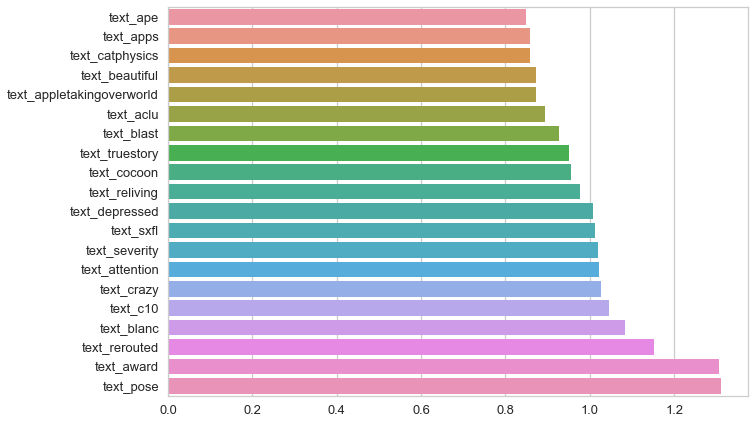

In [104]:
sns.barplot( coef[top_positive_coefficients],feature_names[top_positive_coefficients],)

## Interpretation of positive text:
Here it is shown that the social network did in fact contribute to positive coefficients, along with the popup store and the iPad2. Google's ACLU party, Spark being given an award for positive sentiment about Android, and mislabeled negative sentiment about Marissa Mayer and JC Penney locations are being rerouted to Macys in Google maps stand out as new factors. **NOTE: Some text features, being derived from preprocessed text, do not appear in the original dataframe.**

In [105]:
for c in feature_names[top_positive_coefficients]:
    print("Text feature: " + c.split("_",1)[-1] + "\n --- \n")
    features = df[df['text'].str.contains(c.split('_')[1])]['text'][:6]
    for f in features:
        print(f + "\n")

Text feature: ape
 --- 

No Google Circles at #SxSW link (ht @mention ) (maybe they're reconsidering the shape?)

Here is a list of all the music performers at #SXSW link   I used jQuery to screenscrape it )

USA Today on iPad makes good use of digital shortcuts while still looking like a newspaper @mention #tapworthy #sxsw

The brown paper on the windows as the line grows at the #SXSW PopUp Apple Store by Gold's Gym at Sixth ; Congress link

Ne sapete qualcosa? ÛÏ@mention Google to Launch Major New Social Network Called Circles Possibly Today link #sxswÛ

@mention retiring from Wine Library TV moving onto Daily Grape Get the app on yr iPhone #thankyouecon #SXSW

Text feature: apps
 --- 

Thanks to @mention for her mention of our new #Speech iPad apps being showcased at the #SXSW Conf link #sxswh #sxsh

XMAS!! RT @mention Shiny new @mention @mention @mention apps a new @garyvee book popup iPad 2 stores #SXSW is Christmas for nerds

Any other #Sxsw accounts I need to follow or apps t

## Feature importance - top negative coefficients

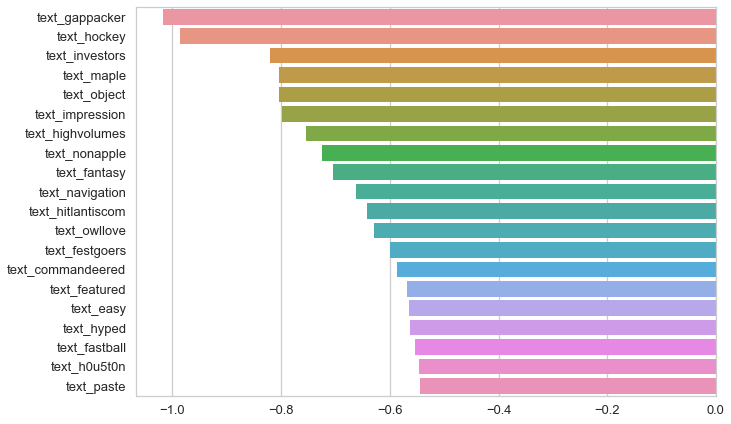

In [106]:
sns.barplot( coef[top_negative_coefficients],feature_names[top_negative_coefficients],)

### Interpretation:
Standing out are design critiques of the iPad 2, mislabeled text praising Google's navigation, and generally that the negative coefficients seem to be less accurate and less common-sense negative than the positive ones, which makes sense given the difficulty predicting this minority class.

In [107]:
for c in feature_names[top_negative_coefficients]:
    print("Text feature: " + c.split("_",1)[-1] + "\n --- \n")
    features = df[df['text'].str.contains(c.split('_')[1])]['text'][:6]
    for f in features:
        print(f + "\n")

Text feature: gappacker
 --- 

Text feature: hockey
 --- 

iPad2 vs Android vs the World With a title like this I have a near hockeyfan esque desire for a fight to break out #gsdm #sxsw #platform

Jesus hockey mask?! I'm worse than I thought #SXSW @mention Apple Store SXSW link

Text feature: investors
 --- 

Developers investors the market segment for iPad apps for those with disabilities is huge $220 billion in spending power #POURsite #sxsw

Text feature: maple
 --- 

Text feature: object
 --- 

&quot;ideas not objects&quot; Robert burner hired Ives at apple #sxsw

When brand focuses on purpose not object they survive ; succeed Google not search useful info Nike not sneakers performance #sxsw

#iPad design tip if it looks like a physical object ppl will interact with it like itÛªs one&quot; #sxsw #tapworthy

Josh Clark's (@mention iPad UI talk is fabulous Full of objective critiques and insightful suggestions link #sxsw

Hey #vufinders awesome new update for @mention #iphone app li

# Undersampling techniques

In [108]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [109]:
from imblearn.under_sampling import NearMiss # doctest: +NORMALIZE_WHITESPACE
print('Original dataset shape %s' % Counter(y))
nm = NearMiss()
X_res, y_res = nm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({1: 5544, 2: 2978, 0: 570})
Resampled dataset shape Counter({0: 382, 1: 382, 2: 382})


In [110]:
model = LinearSVC(class_weight="balanced", random_state=0)
model.fit(X_res, y_res)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.24      0.47      0.31       188
           1       0.70      0.43      0.54      1830
           2       0.40      0.60      0.48       983

    accuracy                           0.49      3001
   macro avg       0.44      0.50      0.44      3001
weighted avg       0.57      0.49      0.50      3001



In [111]:
bal_nm_cohen = cohen_kappa_score(y_test,y_pred)
print(bal_nm_cohen)

0.15054841670320795


## Grid search on undersampling

In [112]:
grid.fit(X_res,y_res)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.0s finished


GridSearchCV(estimator=LinearSVC(class_weight='balanced', random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'max_iter': [1000, 10000],
                         'tol': [0.001, 0.0001, 1e-05]},
             scoring=make_scorer(cohen_kappa_score), verbose=2)

In [113]:
print(grid.best_estimator_)

LinearSVC(C=0.1, class_weight='balanced', random_state=0, tol=0.001)


In [114]:
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

              precision    recall  f1-score   support

           0       0.20      0.61      0.30       188
           1       0.73      0.43      0.54      1830
           2       0.41      0.56      0.47       983

    accuracy                           0.48      3001
   macro avg       0.45      0.53      0.44      3001
weighted avg       0.59      0.48      0.50      3001



In [115]:
grid_nm_cohen = cohen_kappa_score(y_test, grid_predictions)
print(grid_nm_cohen)

0.16991052118851335


# Other undersampling techniques - 
NeighbourhoodCleaningRule is computationally expensive, and produces results that don't outperform the dataset with no resampling, like the other undersampling techniques.

In [116]:
from imblearn.under_sampling import NeighbourhoodCleaningRule
ncr = NeighbourhoodCleaningRule()
X_resampled, y_resampled = ncr.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 382), (1, 3326), (2, 465)]


In [117]:
model = LinearSVC(class_weight="balanced", random_state=0)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.37      0.36      0.37       188
           1       0.67      0.91      0.77      1830
           2       0.72      0.23      0.35       983

    accuracy                           0.65      3001
   macro avg       0.59      0.50      0.49      3001
weighted avg       0.67      0.65      0.61      3001



In [118]:
bal_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)
print(bal_ncr_cohen)

0.16991052118851335


## Tuned SVC on NCR

In [119]:
grid.fit(X_resampled,y_resampled)
grid_predictions = grid.predict(X_test)
print(metrics.classification_report(y_test,grid_predictions))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s


              precision    recall  f1-score   support

           0       0.37      0.36      0.37       188
           1       0.67      0.91      0.77      1830
           2       0.72      0.23      0.35       983

    accuracy                           0.65      3001
   macro avg       0.59      0.50      0.49      3001
weighted avg       0.67      0.65      0.61      3001



[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.6s finished


In [120]:
tune_ncr_cohen = cohen_kappa_score(y_test, grid_predictions)

In [121]:
print(tune_ncr_cohen)

0.23443971624233695


# TBD: Conclusions - 

## TBD: chart of model performance

## TBD: best model results and interpretation

## TBD: 1-3+ Business recomendations

# Future work: Outlier detection approaches, multilabel classification